## 1. Data Acquisition and Preparation

In [172]:
import math
import functools
import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


### 1.1 Define Asset Universe
Create a diverse universe.

In [174]:
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "BAC", "JNJ", "WMT", "XOM",  # U.S. Equities
    "EFA", "EEM",  # International Equities
    "TLT",        # Fixed Income
    "GLD"         # Commodities
]
data = yf.download(tickers, start = "2018-01-01", end = "2025-02-15", auto_adjust = False)

# Display the downloaded data.
data

[*********************100%***********************]  13 of 13 completed


Price        Adj Close                                               \
Ticker            AAPL        AMZN        BAC        EEM        EFA   
Date                                                                  
2018-01-02   40.479843   59.450500  25.191648  40.948372  57.591282   
2018-01-03   40.472797   60.209999  25.107397  41.340710  57.867725   
2018-01-04   40.660782   60.479500  25.435982  41.545414  58.501930   
2018-01-05   41.123714   61.457001  25.553932  41.903633  58.827171   
2018-01-08   40.970982   62.343498  25.377005  41.903633  58.810917   
...                ...         ...        ...        ...        ...   
2025-02-10  227.649994  233.139999  46.377323  43.720001  80.150002   
2025-02-11  232.619995  232.759995  46.496574  43.549999  80.529999   
2025-02-12  236.869995  228.929993  45.920212  43.790001  80.830002   
2025-02-13  241.529999  230.369995  46.039459  44.070000  81.809998   
2025-02-14  244.600006  228.679993  46.665508  44.410000  81.930000   

Price                                                                   ...  \
Ticker             GLD       GOOGL         JNJ         JPM        MSFT  ...   
Date                                                                    ...   
2018-01-02  125.150002   53.405174  113.850304   87.571899   79.474152  ...   
2018-01-03  124.820000   54.316315  114.937836   87.661102   79.844002  ...   
2018-01-04  125.459999   54.527306  114.929665   88.916908   80.546776  ...   
2018-01-05  125.330002   55.250351  115.878227   88.346100   81.545425  ...   
2018-01-08  125.309998   55.445415  116.025383   88.476562   81.628624  ...   
...                ...         ...         ...         ...         ...  ...   
2025-02-10  268.369995  186.255493  153.015182  269.380737  411.395111  ...   
2025-02-11  267.390015  185.106827  154.890167  273.306549  410.616669  ...   
2025-02-12  267.670013  183.398788  154.027069  273.763763  408.221466  ...   
2025-02-13  270.309998  185.925873  156.001266  274.628418  409.718475  ...   
2025-02-14  266.290009  185.016907  154.910004  274.896759  407.612671  ...   

Price         Volume                                                    \
Ticker           EEM       EFA       GLD     GOOGL       JNJ       JPM   
Date                                                                     
2018-01-02  68969400  26530000  11762500  31766000   6842100  13578800   
2018-01-03  56228700  33384900   7904300  31318000   5350500  11901000   
2018-01-04  52154900  23974400   7329700  26052000   4837600  12953700   
2018-01-05  50026900  17483800   5739900  30250000   6158800  14155000   
2018-01-08  36998200  21733700   3566700  24644000   5129800  12466500   
...              ...       ...       ...       ...       ...       ...   
2025-02-10  19596700   7287300  13250300  23105600   6936200   8627400   
2025-02-11  19596800   7583700   7169500  21239500   7554500   7196400   
2025-02-12  19986000  17271400   9328600  22072600   7746000   6683900   
2025-02-13  22841000  17212300   8347500  21402500  10704700   8398700   
2025-02-14  24329400   8051800  11546700  20448400   6411800   5688600   

Price                                               
Ticker          MSFT       TLT       WMT       XOM  
Date                                                
2018-01-02  22483800  16238200  30451500  11469300  
2018-01-03  26061400   8605100  26710800  13957700  
2018-01-04  21912000   9217900  20491200  10863000  
2018-01-05  23407100  10915400  21852000  11047600  
2018-01-08  22113000   8850600  26531700  10927100  
...              ...       ...       ...       ...  
2025-02-10  20817900  22736100  15274600  12142200  
2025-02-11  18140600  21513000  11953600  12713100  
2025-02-12  19121700  48536200  15162100  18244100  
2025-02-13  23891700  42718100  12604400  15460000  
2025-02-14  22758500  27460700  14109500  15733500  

[1791 rows x 78 columns]

## 2. Feature Engineering

Compute factros :

- Momentum :
    Calculate momentum as the percentage change over a specified window.
- Volatility :
    Compute rolling volatility using the standard deviation of daily returns (which approximate log daily returns).
- Average Volume :
    Determine the rolling average volume over the lookback period.


As I am going to build a dynamic portfolio, I define also lookback period and rebalance period.

In [176]:
lookback = 126
rebalance_period = 21

adj_close = data["Adj Close"].dropna()
daily_returns = adj_close.pct_change().dropna()

momentum = (adj_close / adj_close.shift(21) -1).dropna()
volatility = (np.log(1 + daily_returns)).rolling(lookback).std().dropna()
avgvolume = data["Volume"].rolling(lookback).mean().dropna()

factors_df = pd.DataFrame({})

for ticker in tickers :
    factors_df[f"Momentum_{ticker}"] = momentum[ticker]
    factors_df[f"Volatility_{ticker}"] = volatility[ticker]
    factors_df[f"AvgVolume_{ticker}"] = avgvolume[ticker]
    
factors_df.dropna(how = "any")

,Momentum_AAPL,Volatility_AAPL,AvgVolume_AAPL,Momentum_MSFT,Volatility_MSFT,AvgVolume_MSFT,Momentum_AMZN,Volatility_AMZN,AvgVolume_AMZN,Momentum_GOOGL,...,AvgVolume_EFA,Momentum_EEM,Volatility_EEM,AvgVolume_EEM,Momentum_TLT,Volatility_TLT,AvgVolume_TLT,Momentum_GLD,Volatility_GLD,AvgVolume_GLD
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,-0.041234,0.015174,1.308631e+08,-0.025769,0.016675,3.049652e+07,0.017228,0.017895,1.039207e+08,-0.031881,...,2.655972e+07,-0.076699,0.013021,7.215175e+07,0.023832,0.006128,8.977711e+06,-0.030400,0.006081,7.402794e+06
2018-07-05,-0.040919,0.015188,1.304531e+08,-0.023779,0.016681,3.044030e+07,0.001993,0.017873,1.039007e+08,-0.008453,...,2.644233e+07,-0.071926,0.012989,7.224037e+07,0.024367,0.006119,8.940055e+06,-0.030932,0.006087,7.379362e+06
2018-07-06,-0.030983,0.015229,1.302960e+08,-0.012977,0.016706,3.041905e+07,0.008775,0.017875,1.038417e+08,0.007088,...,2.638413e+07,-0.073110,0.013044,7.238147e+07,0.036112,0.006126,8.904039e+06,-0.033030,0.006068,7.344578e+06
2018-07-09,-0.014887,0.015244,1.301721e+08,0.009615,0.016684,3.037782e+07,0.029432,0.017878,1.037571e+08,0.028966,...,2.640951e+07,-0.041820,0.013123,7.262374e+07,0.019569,0.006147,8.864652e+06,-0.030197,0.006073,7.331363e+06
2018-07-10,-0.007042,0.015240,1.300251e+08,0.004821,0.016685,3.035544e+07,0.035083,0.017848,1.035545e+08,0.030396,...,2.638767e+07,-0.042132,0.013123,7.283652e+07,0.022556,0.006147,8.840121e+06,-0.033168,0.006075,7.332856e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10,-0.060979,0.013499,4.879313e+07,-0.029065,0.014038,2.040215e+07,0.049566,0.017584,3.667432e+07,-0.038567,...,1.096591e+07,0.045933,0.010517,2.659166e+07,0.038214,0.008184,3.763072e+07,0.091556,0.009314,6.709295e+06
2025-02-11,-0.016780,0.013579,4.888453e+07,-0.017926,0.014021,2.039313e+07,0.063122,0.017585,3.657363e+07,-0.034993,...,1.093862e+07,0.059869,0.010514,2.657939e+07,0.038445,0.008150,3.754636e+07,0.077273,0.009324,6.730950e+06
2025-02-12,0.011649,0.013657,4.894180e+07,-0.019535,0.014030,2.041185e+07,0.047926,0.017665,3.659119e+07,-0.038741,...,1.101229e+07,0.073021,0.010521,2.661862e+07,0.024713,0.008225,3.773902e+07,0.089241,0.009218,6.760849e+06


## 3. Exploratory Data Analysis

### 3.1 Correlation Matrix

Visualize the correlation between computed factors and daily returns.

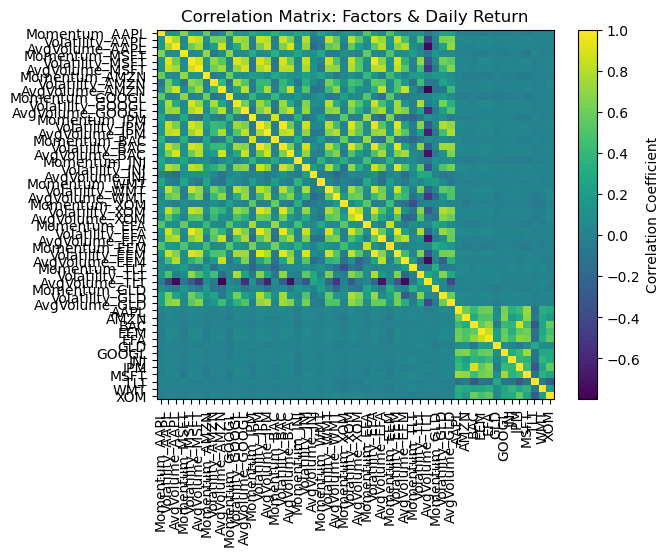

Factor Correlation Matrix:
                   Momentum_AAPL  Volatility_AAPL  AvgVolume_AAPL  \
Momentum_AAPL          1.000000         0.147406        0.143011   
Volatility_AAPL        0.147406         1.000000        0.772319   
AvgVolume_AAPL         0.143011         0.772319        1.000000   
Momentum_MSFT          0.669024         0.058044        0.090795   
Volatility_MSFT        0.135618         0.912065        0.598090   
AvgVolume_MSFT         0.124215         0.835484        0.756803   
Momentum_AMZN          0.573412         0.080823        0.041131   
Volatility_AMZN       -0.075194         0.616575        0.217680   
AvgVolume_AMZN         0.060653         0.634546        0.878406   
Momentum_GOOGL         0.549097         0.006669        0.015465   
Volatility_GOOGL       0.138411         0.777459        0.306811   
AvgVolume_GOOGL        0.111842         0.709950        0.746182   
Momentum_JPM           0.302788        -0.029458       -0.057938   
Volatility_JPM      

In [179]:

shifted_factors = factors_df.shift(1)
factors_return_corr = pd.concat([shifted_factors, daily_returns], axis = 1).corr()

plt.figure()
plt.imshow(factors_return_corr, aspect = "auto")
plt.colorbar(label = "Correlation Coefficient")
plt.xticks(range(len(factors_return_corr.columns)), factors_return_corr.columns, rotation = 90)
plt.yticks(range(len(factors_return_corr.columns)), factors_return_corr.columns)
plt.title("Correlation Matrix: Factors & Daily Return")
plt.show()

print("Factor Correlation Matrix:\n", factors_return_corr)


### 3.2 Histograms

Plot histograms to explore the distribution of daily returns for each asset.

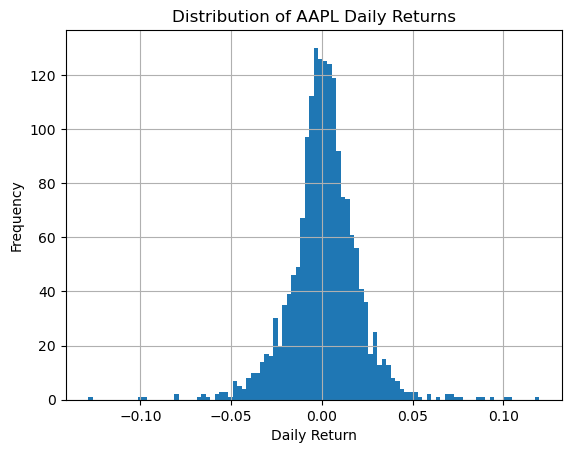

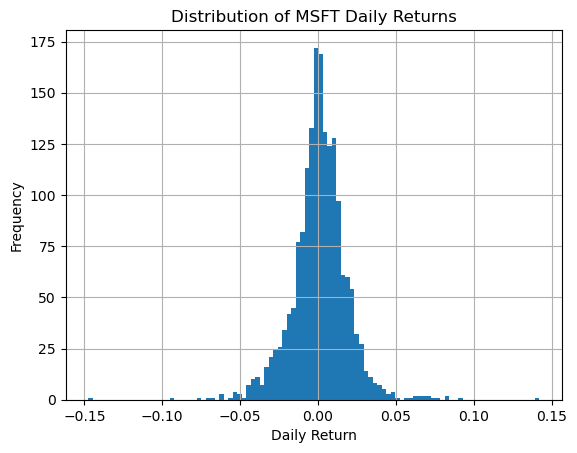

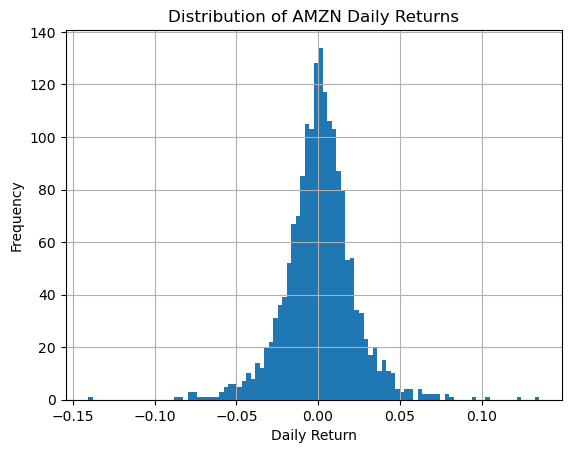

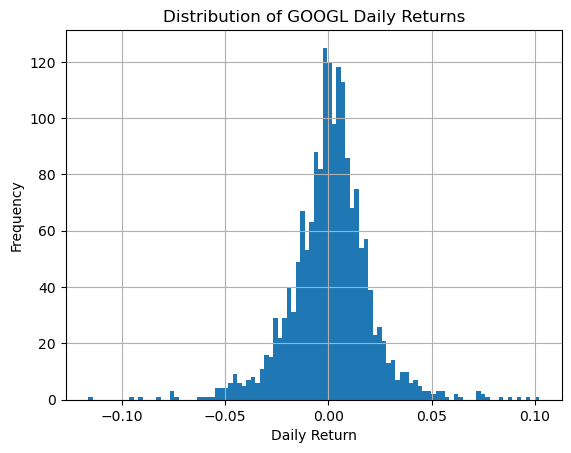

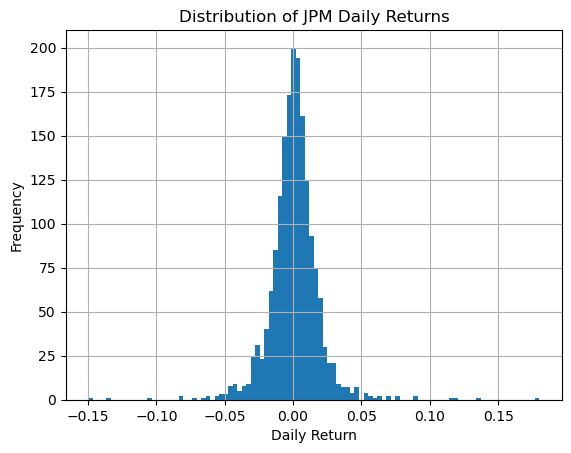

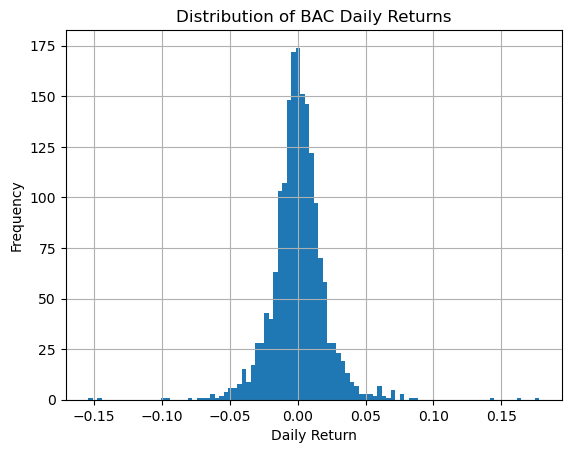

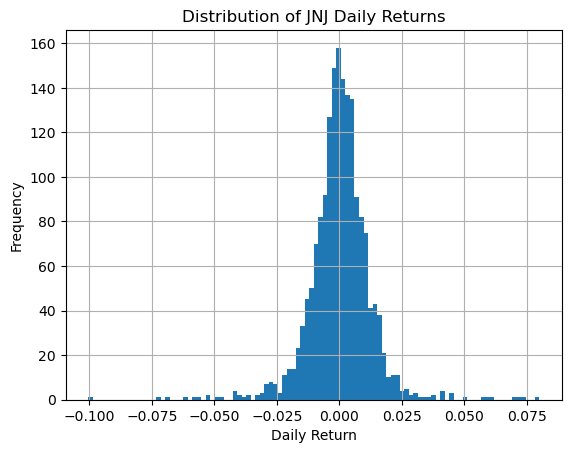

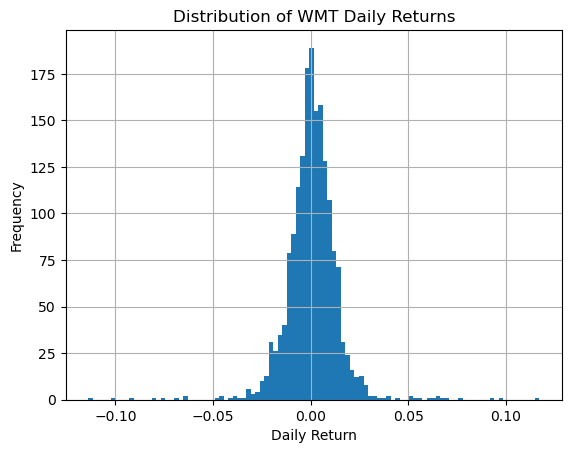

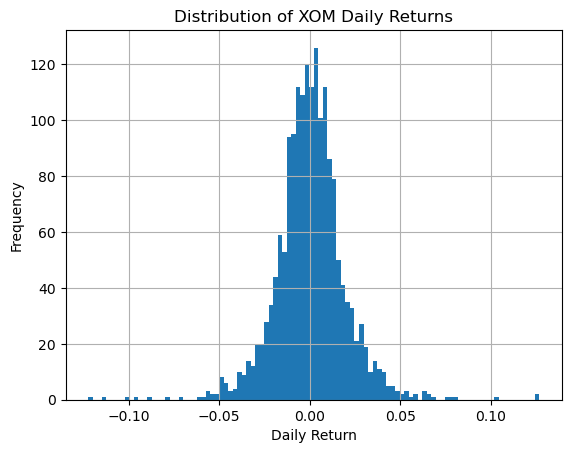

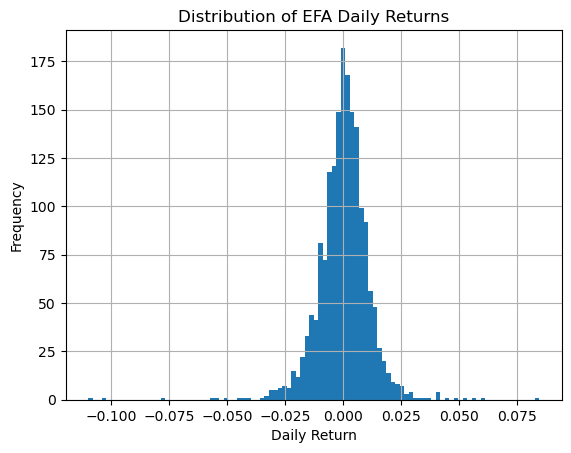

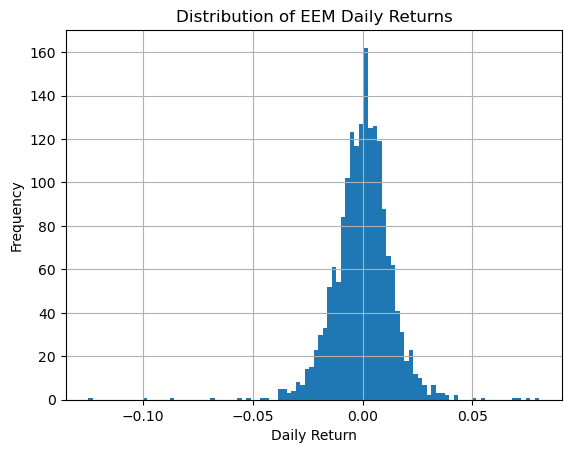

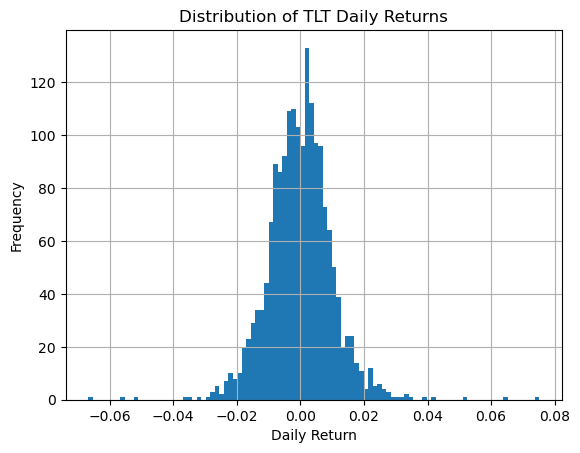

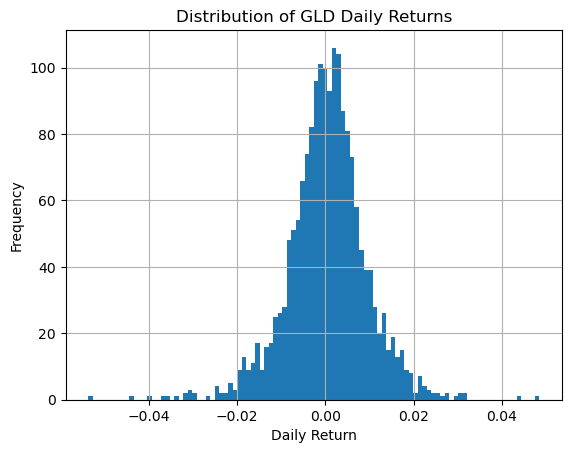

In [181]:
for ticker in tickers :
    daily_returns[f"{ticker}"].hist(bins = 100)
    plt.title(f"Distribution of {ticker} Daily Returns")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.show()


### 3.3 Scatter Plots

Examine the relationship between each factor (momentum, volatility, average volume) and the respective asset returns, identifying outliers or patterns.

We can see many outliers and high-leverage points.

C:\Users\kamiq\AppData\Local\Temp\ipykernel_26832\1836016384.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


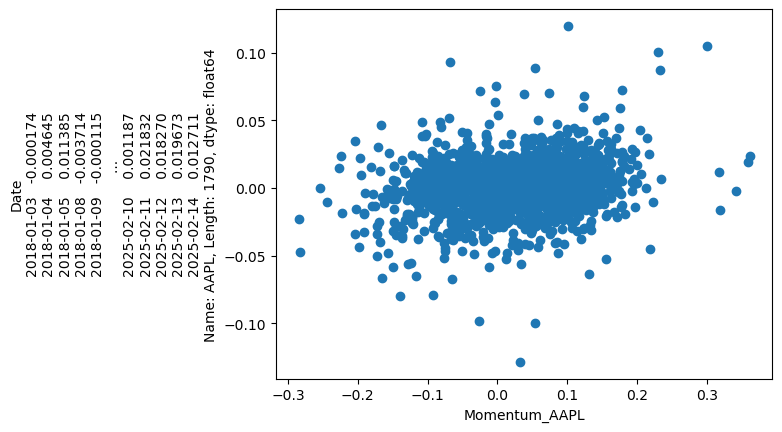

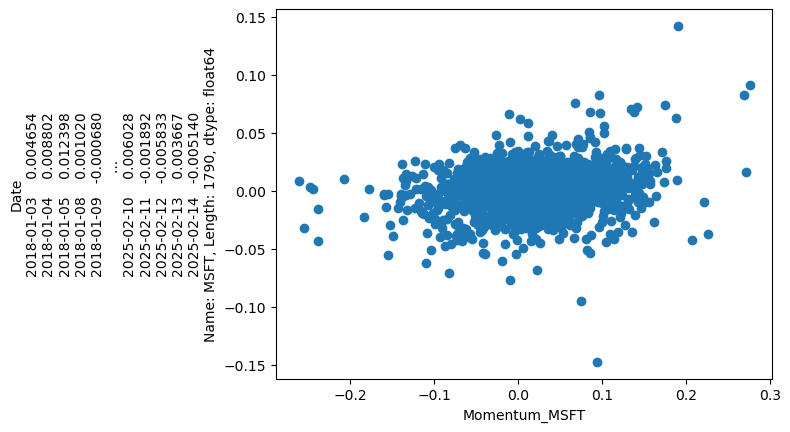

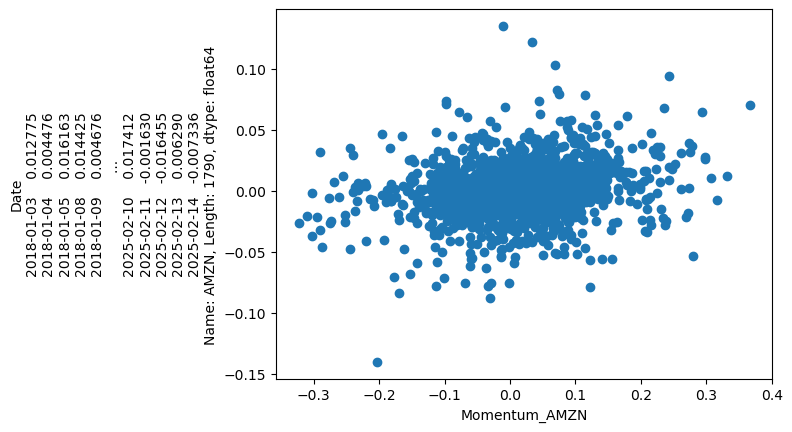

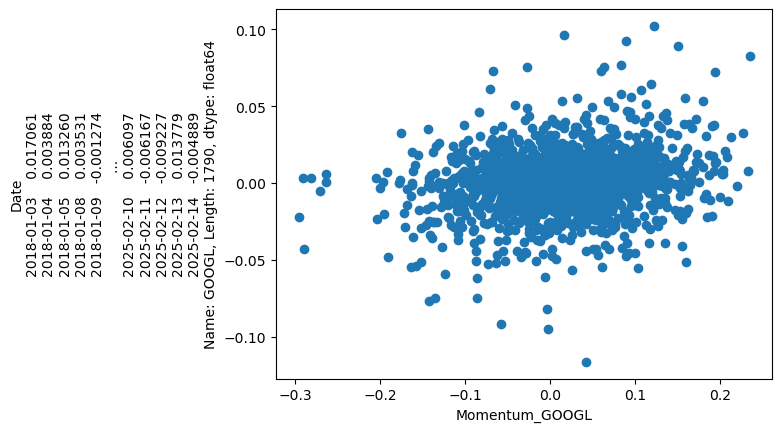

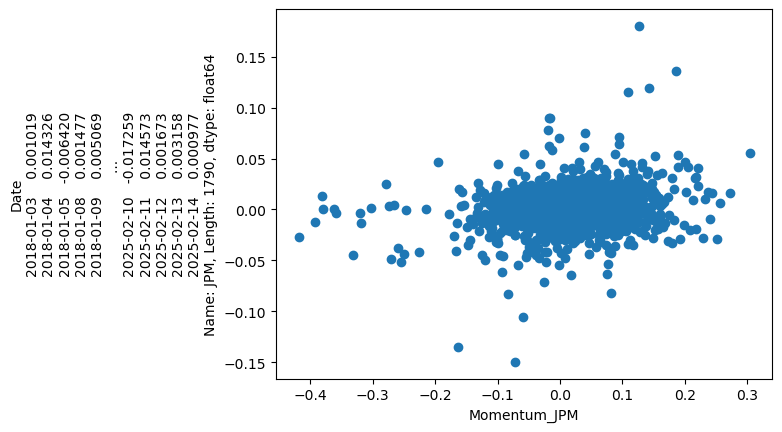

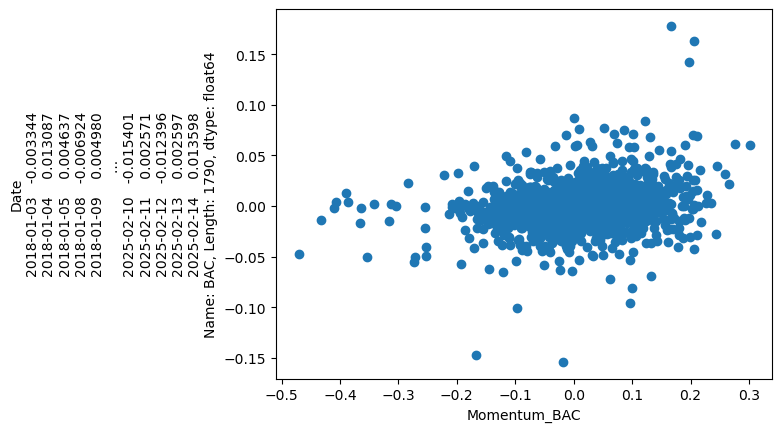

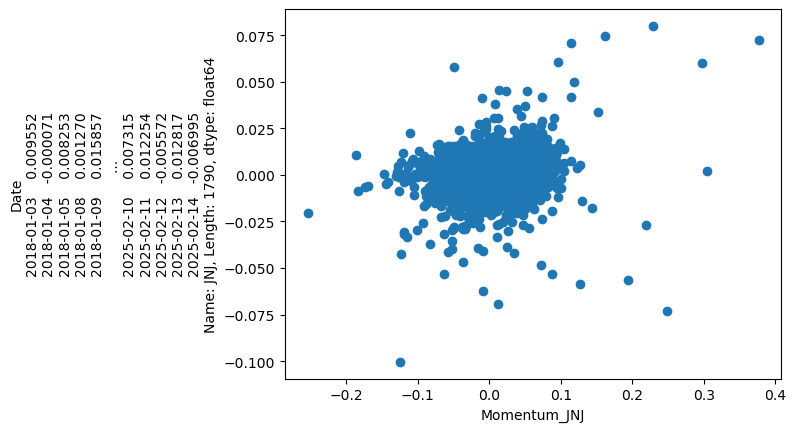

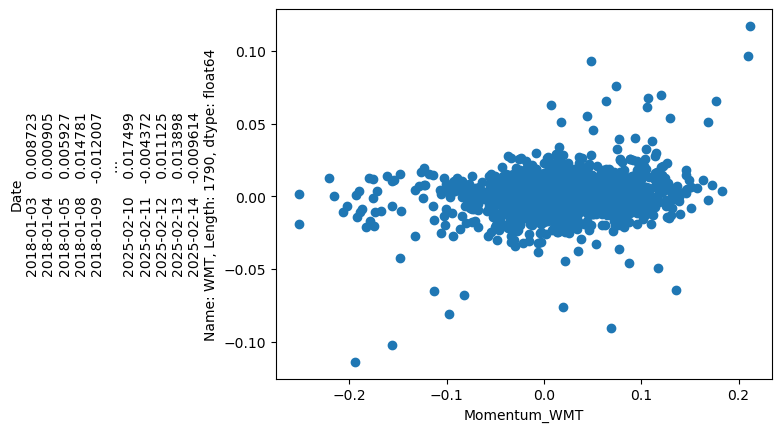

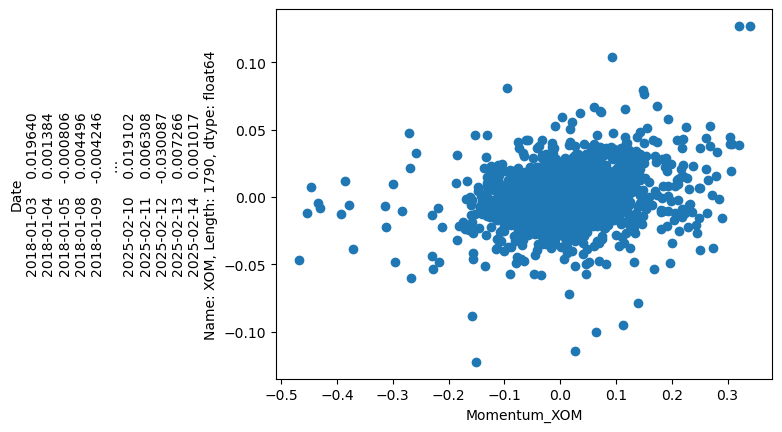

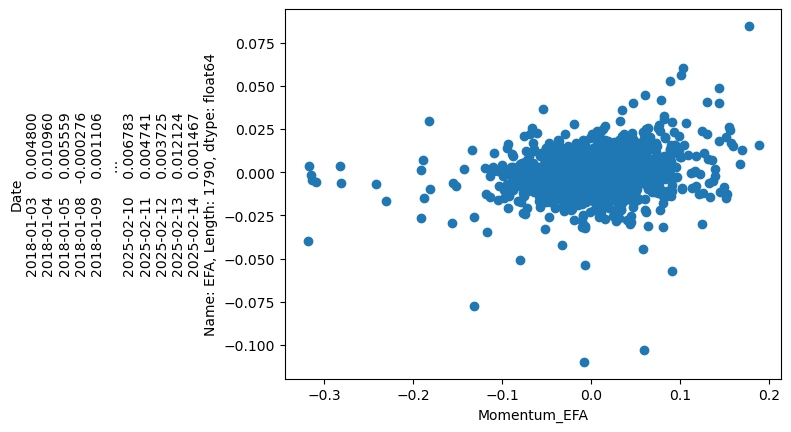

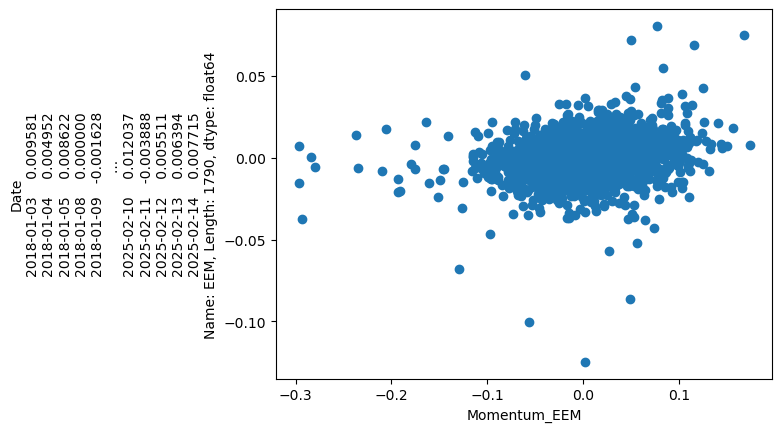

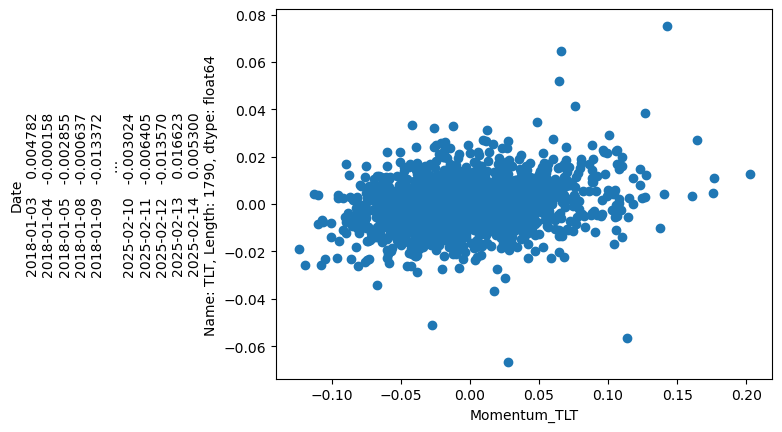

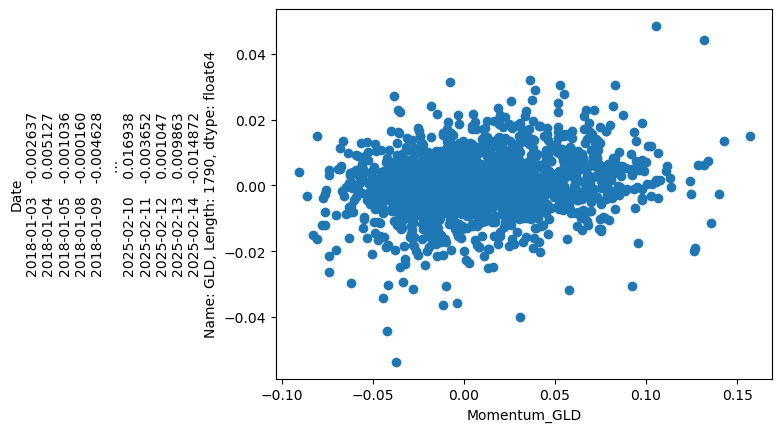

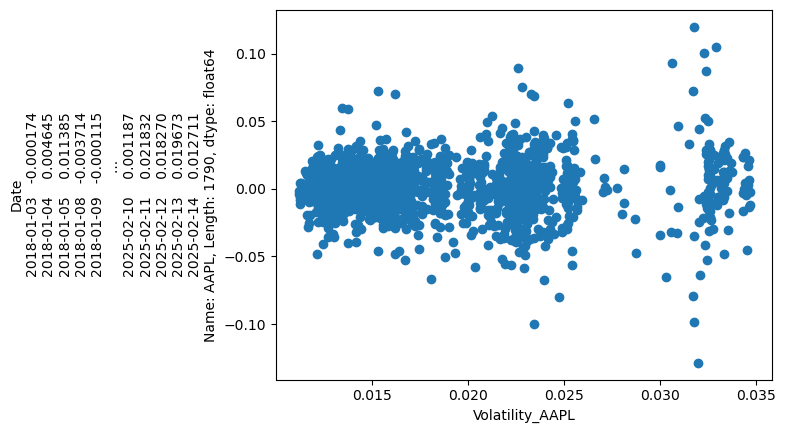

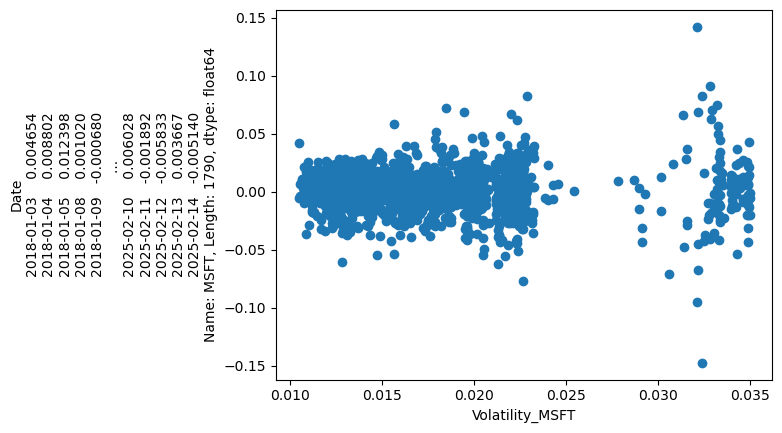

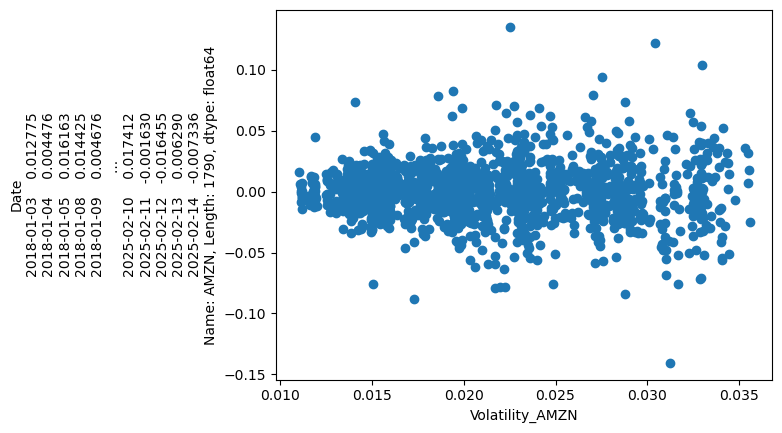

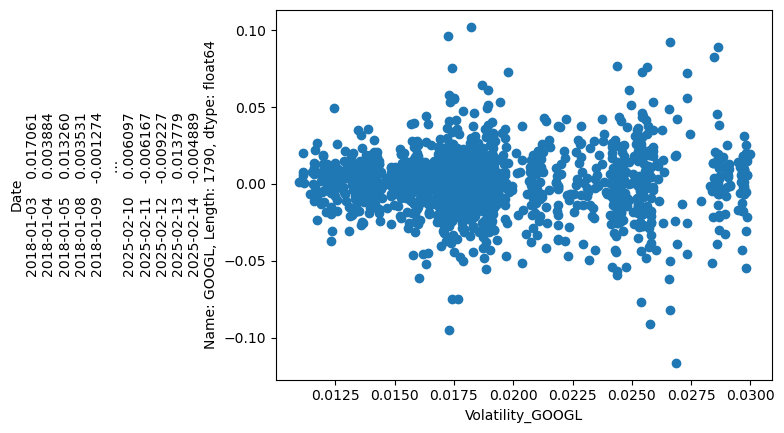

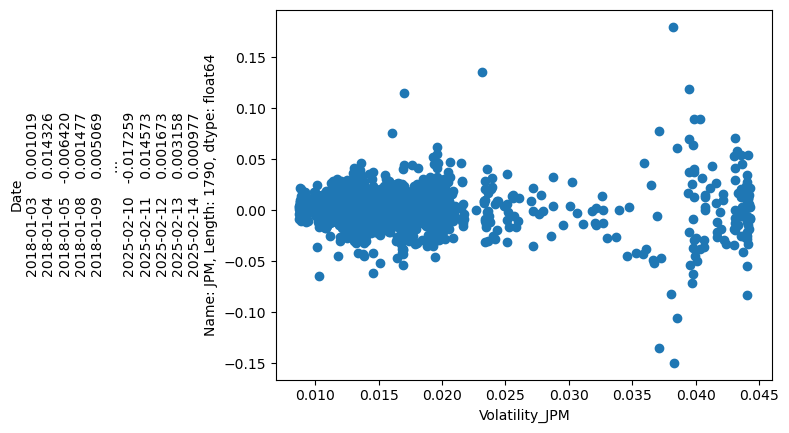

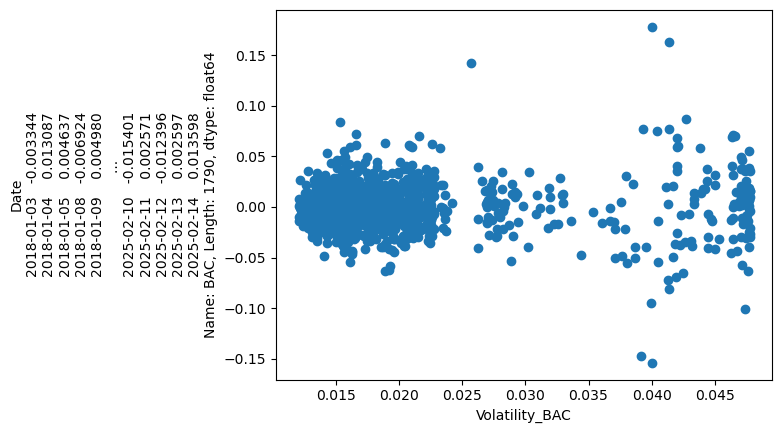

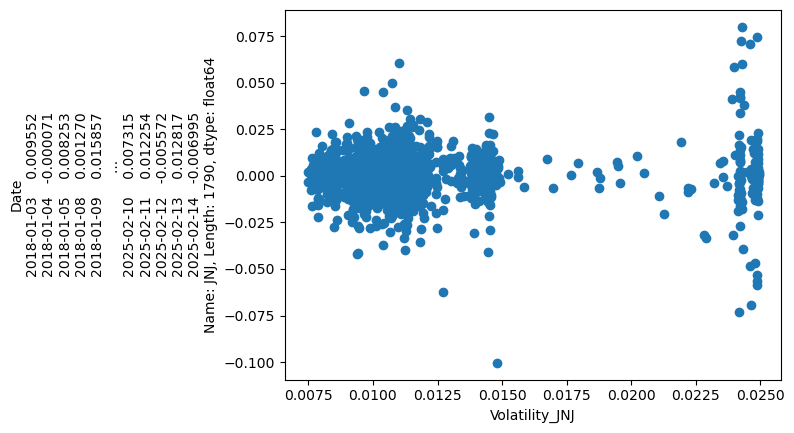

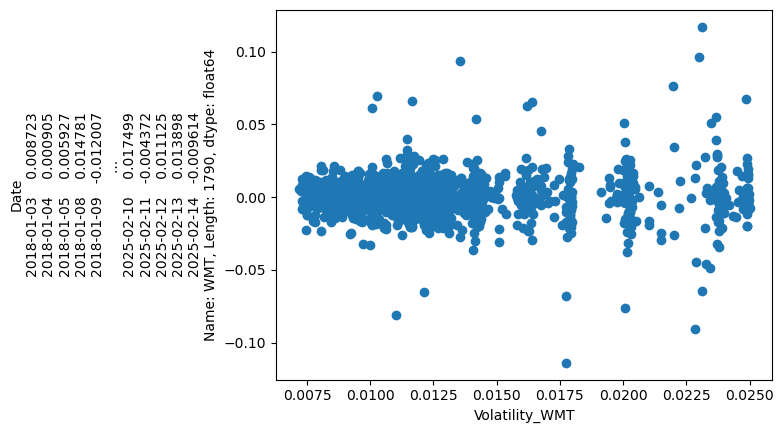

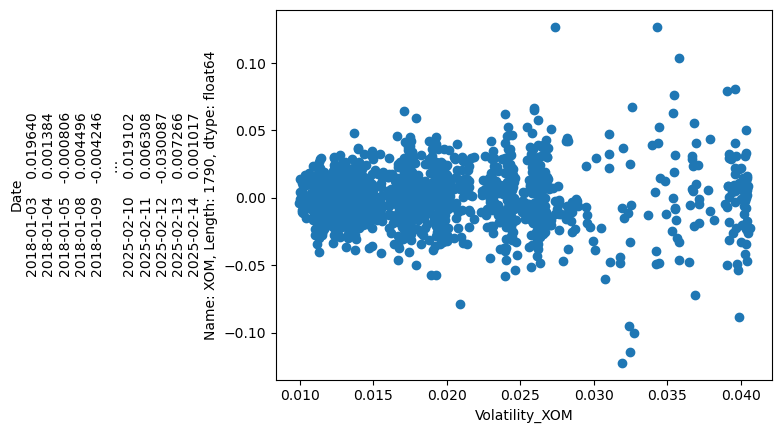

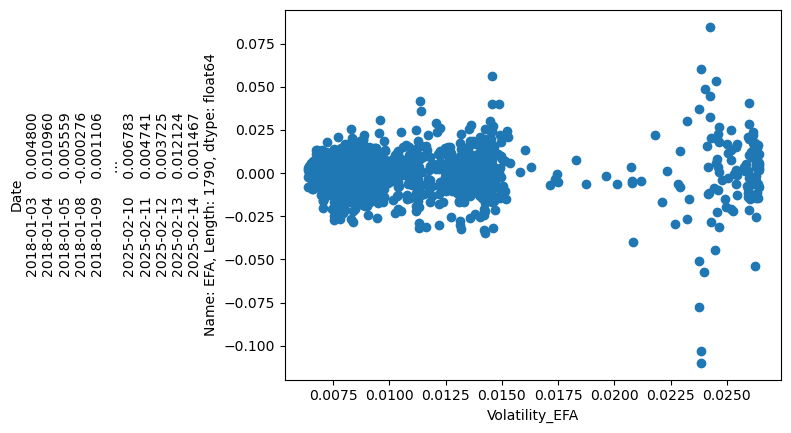

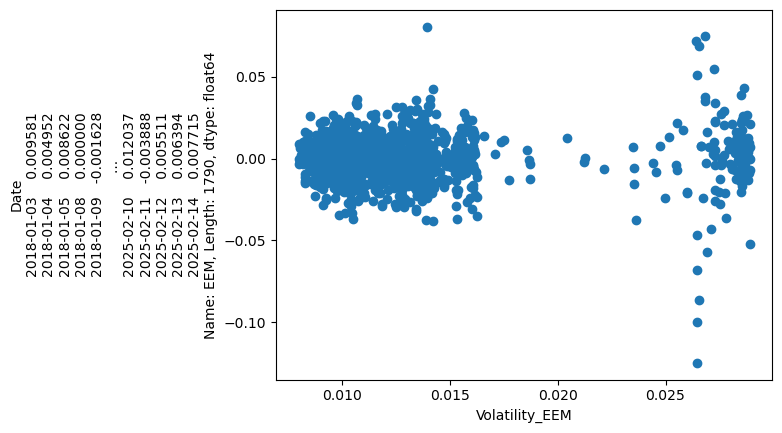

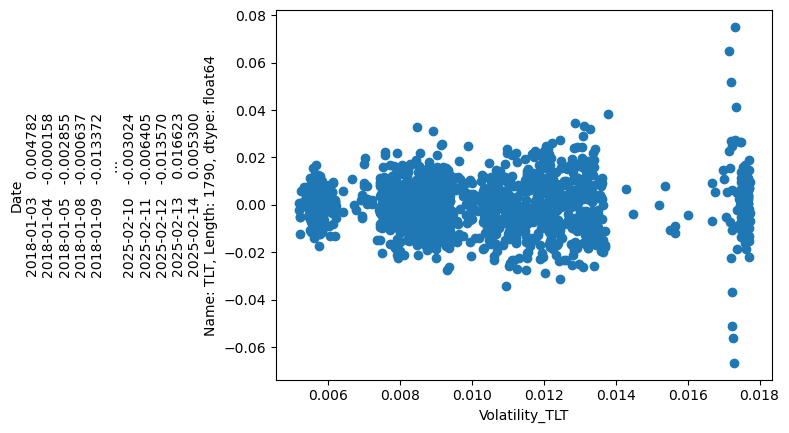

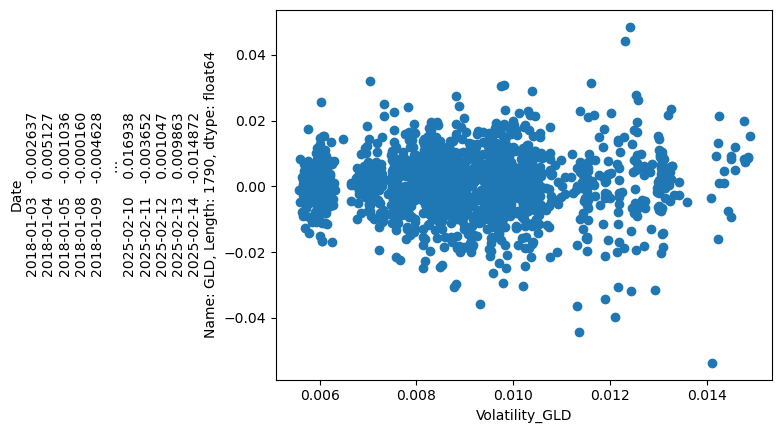

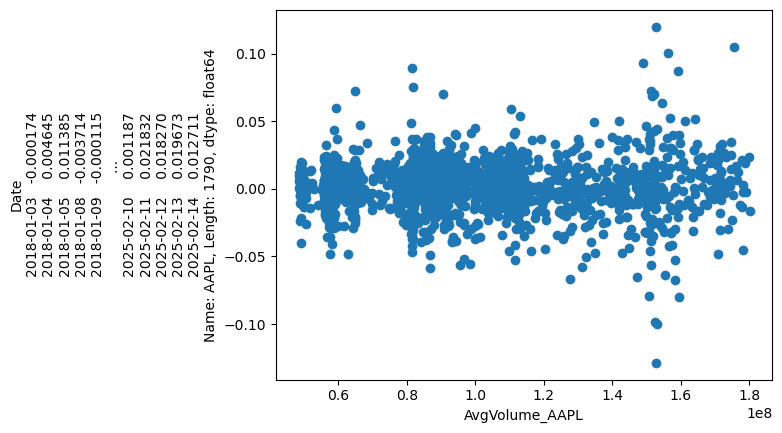

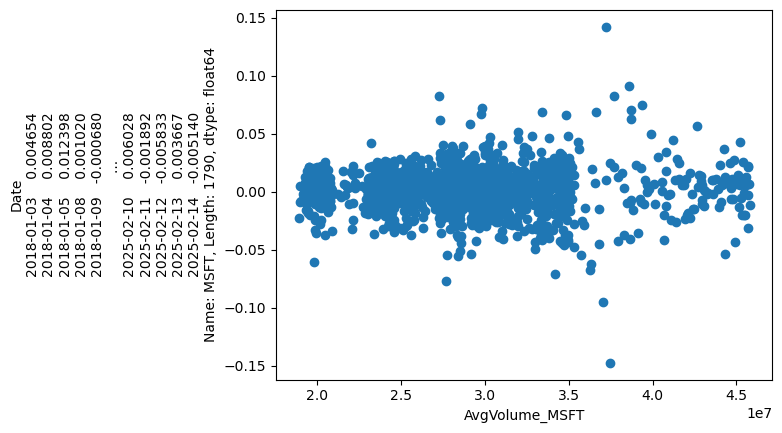

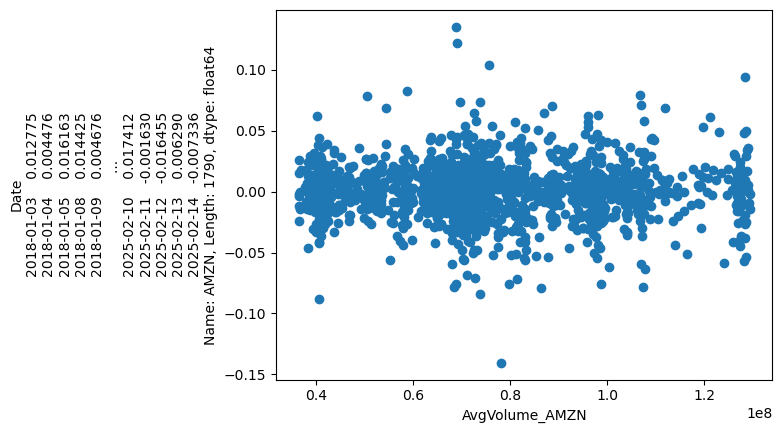

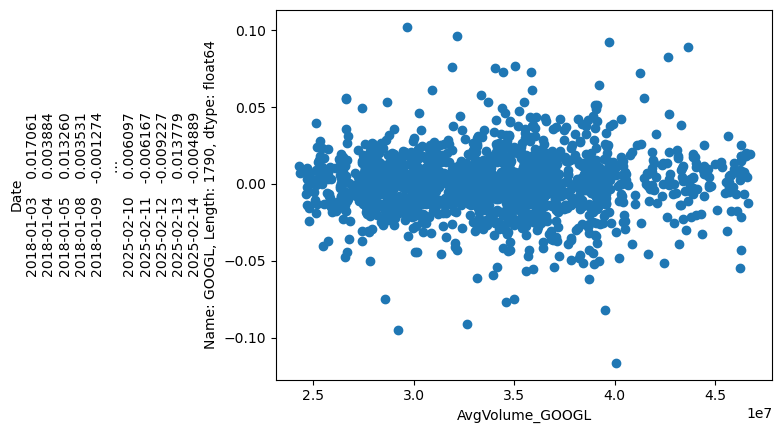

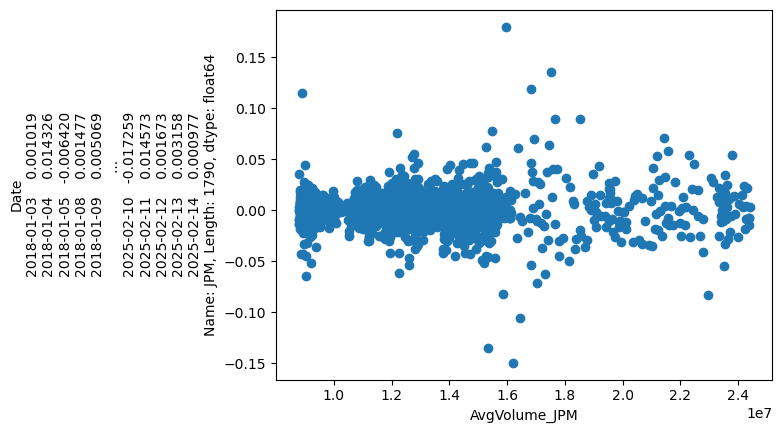

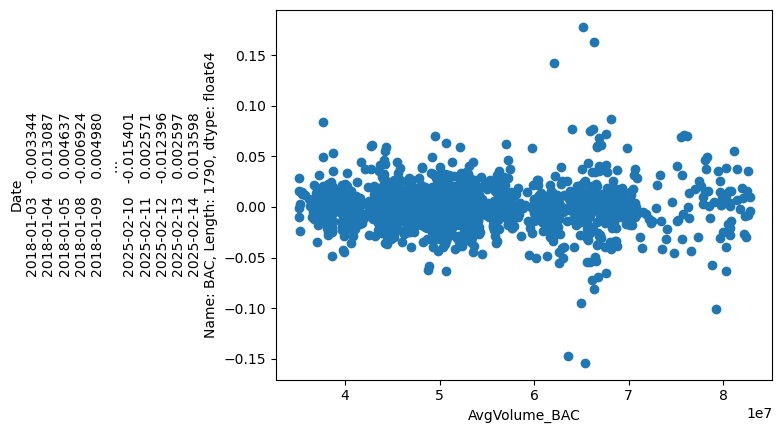

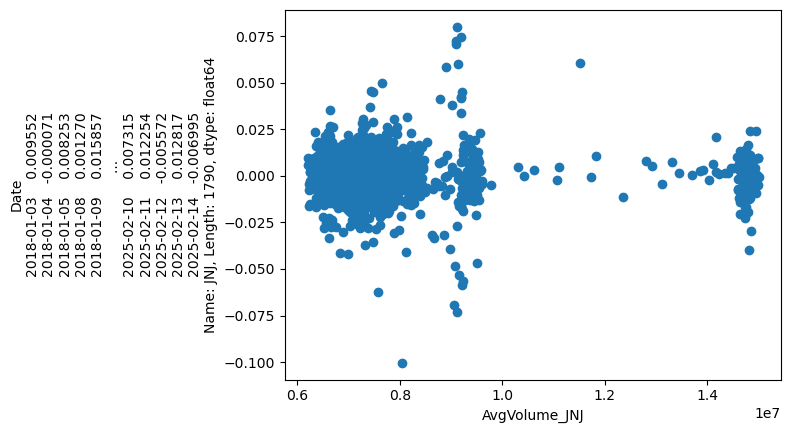

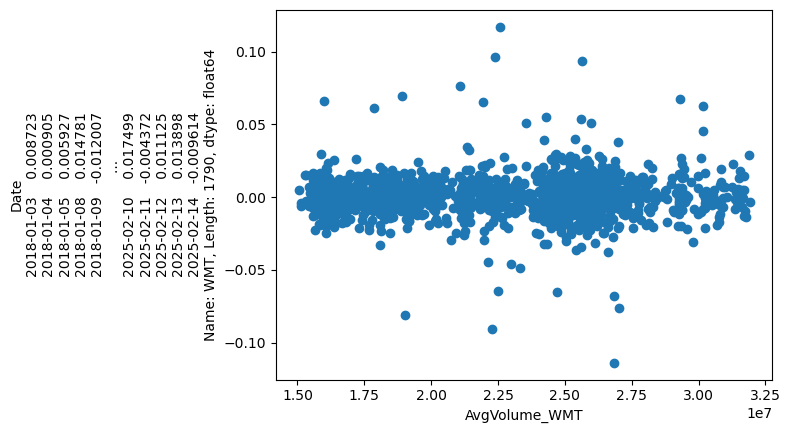

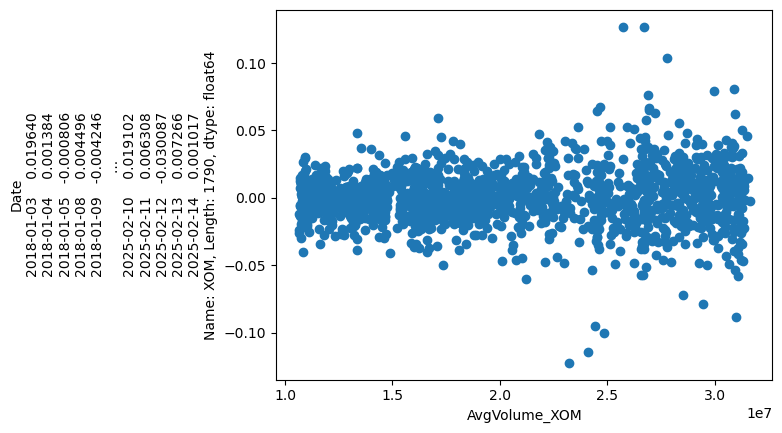

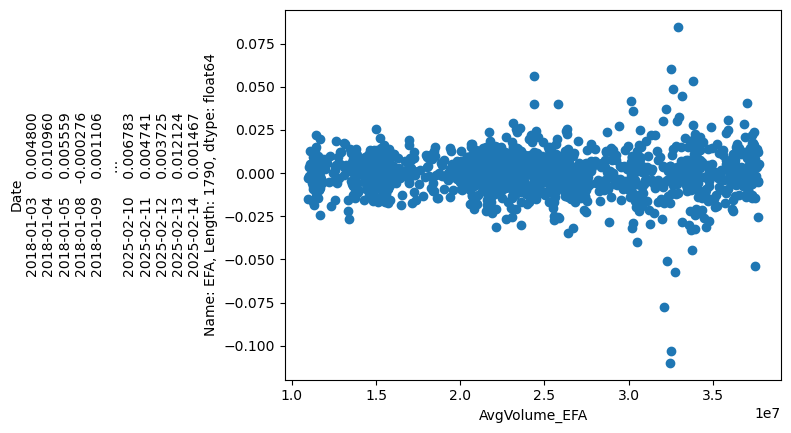

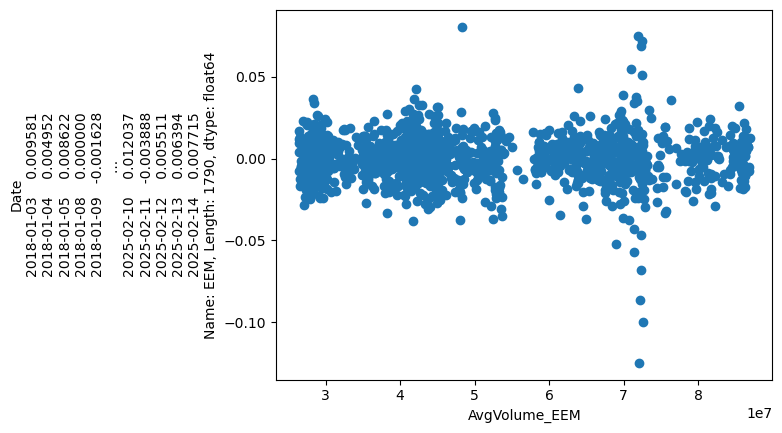

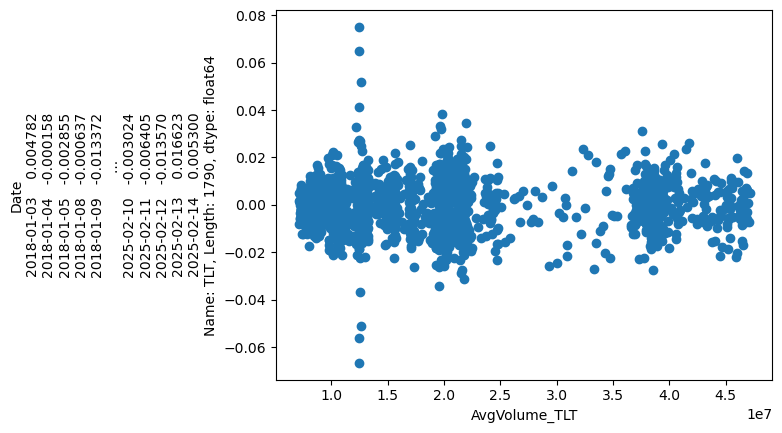

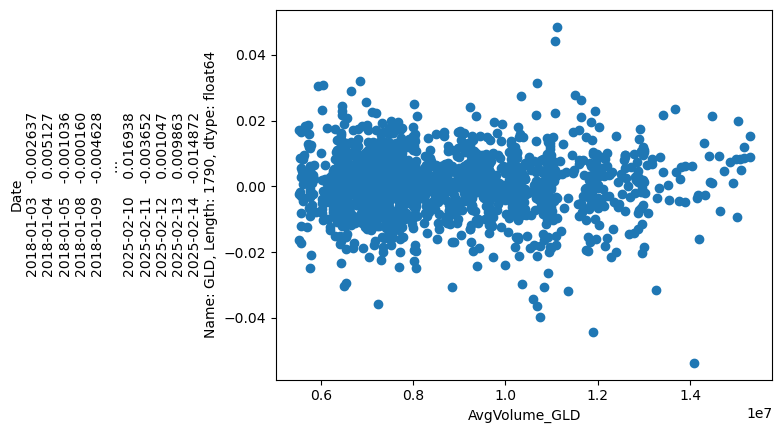

In [192]:
factors_list = ["Momentum", "Volatility", "AvgVolume"]
for factor in factors_list :
    for ticker in tickers :
        plt.figure()
        plt.scatter(factors_df[f"{factor}_{ticker}"], daily_returns[f"{ticker}"].shift(rebalance_period - 1).dropna())
        plt.xlabel(f"{factor}_{ticker}")
        plt.ylabel(daily_returns[f"{ticker}"])


### 4. Machine Learning-Based Return Forecasting

### 4.1 XGBoost Model

In [196]:
def train_predict_xgboost(feature_df, target_series):
    X_train = feature_df.iloc[:-1]
    y_train = target_series.iloc[:-1]
    X_current = feature_df.iloc[[-1]]
    
    model_xgb = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 10, random_state = 42)
    model_xgb.fit(X_train, y_train)
    prediction = model_xgb.predict(X_current)[0]
    return prediction

## 5. Constructing Investor Views via Black-Litterman Framework

### 5.1 Compute $\Omega$ 

Calculate the view uncertainty (diagonal matrix) as $\Omega = diag(\tau \times P_i \times \Sigma \times P_i^T$) for each view row $i$ in $P$.

In [200]:
def compute_Omega(P, Sigma, tau):
    omega_diag = []
    for i in range(P.shape[0]):
        P_i = P[i, :]
        var_view = tau * (P_i @ Sigma @ P_i.T)
        omega_diag.append(var_view)
    return np.diag(omega_diag)

### 5.2 Compute $\mu_{BL}$ 

Compute Black-Litterman adjusted expected returns as 
$$
\mu_{BL} = \left[ (\tau \Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1} \left[ (\tau \Sigma)^{-1} \pi + P^T \Omega^{-1} Q \right]
$$

In [203]:
PERTURB_Q = False

def compute_mu_BL(pi, Sigma, P, Q, tau, Omega):
    """
    Compute Black-Litterman adjusted expected returns, optionally
    perturbing Q by ε ~ N(0, Ω_ii) when PERTURB_Q is True.
    """
    global PERTURB_Q
    
    # If flag is set, add elementwise noise to Q
    if PERTURB_Q:
        eps = np.random.normal(
            loc=0.0,
            scale=np.sqrt(np.diag(Omega)),
            size=Q.shape
        )
        Q = Q + eps

    inv_tauSigma = np.linalg.inv(tau * Sigma)
    inv_Omega    = np.linalg.inv(Omega)
    A = inv_tauSigma + P.T @ inv_Omega @ P
    B = inv_tauSigma @ pi      + P.T @ inv_Omega @ Q
    mu_BL = np.linalg.inv(A) @ B
    return mu_BL

### 5.3 Rule-based signal 

Construct a rule-based signal, which will be used later to adjust $Q$ : For each asset, compare its AvgVolume with every other asset. 
If AvgVolume(asset) > AvgVolume(other), asset gets an advantage of (AvgVolume(asset)/AvgVolume(other)-1).

In [206]:
def rule_based_view(avgvol_series):
    tickers_local = avgvol_series.index.tolist()
    signals = {}
    for asset in tickers_local:
        advantages = []
        for other in tickers_local:
            if asset == other:
                continue
            if avgvol_series.loc[asset] > avgvol_series.loc[other]:
                advantages.append(avgvol_series.loc[asset] / avgvol_series.loc[other] - 1)
        signals[asset] = np.mean(advantages) if advantages else 0.0
    return pd.Series(signals)

## 5.4 Generate Views 

Assumption : $P$ will always be the identity matrix in this project for simplicity.

To compute the final $Q$ (at the next step) I use the following strategy : 

- Generate Machine Learning-Based Views ($Q_{ml}$) :
    Use historical features with ML models described above (XGBoost) to predict future asset returns.
- Rule-Based Views ($Q_{rule}$) :
    Create signals based on relative average trading volumes. Thie is the previous step.
- Combine Views :
    Merge ML-based predictions and rule-based signals to form the temporary view vector $Q$.
- Adjust by $\alpha$ :
  My idea is that I am going to hold the portfolio until the next rebalancing date. If the $\alpha$ during this period is higher then the $\alpha$ during the previous period, that means my strategy is correct, and my final $Q$ will be $2\times \exp(\alpha - \alpha_{prev}) \times Q$. Conversely if the $\alpha$ during this period is lower then the $\alpha$ during the previous period, that means my strategy is not correct, and my final $Q$ will be $0.75\times \exp(\alpha - \alpha_{prev}) \times Q$. If $\alpha$ remains the same I don't change my $Q$. Here $2$ and $0.75$ are risk-aversion coefficients.

Why I generate different $Q$, i.e. $Q_{ml}$ and $Q_{rule}$ ?
  - By taking the simple average, extreme predictions from either approach (which might be noisy or volatile) are moderated.
  - Combining different types of signals can improve the model's ability to generalize on unseen data.

In [209]:
def construct_views_at_date(rebalance_date, factors_df, lookback, rebalance_period):
    Q_ml = {}
    for ticker in tickers:
        feat_cols = [f"Momentum_{ticker}", f"Volatility_{ticker}", f"AvgVolume_{ticker}"]
        # Extract the asset's feature data over the lookback window ending at rebalance_date.
        df_asset = factors_df.loc[:rebalance_date, feat_cols].tail(lookback)
        
        # Define a target: for example, using the forward momentum (shifted by -rebalance_period).
        target_series = df_asset[f"Momentum_{ticker}"].shift(-rebalance_period)
        
        # Align the training data by dropping rows with missing target values.
        valid_idx = df_asset.index.intersection(target_series.dropna().index)
        df_asset = df_asset.loc[valid_idx]
        target_series = target_series.loc[valid_idx]
        
        # If there is insufficient data, set the prediction to zero.
        if len(df_asset) < 10:
            Q_ml[ticker] = 0.0
        else:
            Q_ml[ticker] = train_predict_xgboost(df_asset, target_series)
            

    # Build rule-based signal using the most recent average volume over the lookback period.
    avgvol_dict = {}
    for ticker in tickers:
        col = f"AvgVolume_{ticker}"
        avgvol_dict[ticker] = factors_df.loc[:rebalance_date, col].tail(lookback).mean()
    avgvol_series = pd.Series(avgvol_dict)
    rule_signal = rule_based_view(avgvol_series)
    Q_rule = {ticker: rule_signal.loc[ticker] for ticker in tickers}
    
    Q_combined = {ticker: (Q_ml[ticker] + Q_rule[ticker]) / 2.0 for ticker in tickers}
    
    # Construct P as an identity matrix (absolute views for each asset).
    P = np.eye(len(tickers))
    Q = np.array([Q_combined[ticker] for ticker in tickers])
    
    return P, Q

### 5.5 Compute final $Q$

In [212]:
def adjust_Q(Q, portfolio_alpha, prev_portfolio_alpha):
    if portfolio_alpha - prev_portfolio_alpha > 0:
        return 2 * math.exp(portfolio_alpha - prev_portfolio_alpha) * Q
    elif portfolio_alpha - prev_portfolio_alpha == 0:
        return 1 * Q
    else:
        return 0.75 * math.exp(portfolio_alpha - prev_portfolio_alpha) * Q

## 6. Portfolio Optimization

- Optimization Setup :
    Formulate an optimization problem targeting the maximization of the portfolio Sharpe ratio.

- Constraints :
    - Budget Constraint :
        The sum of portfolio weights equals 1.
    - No Short-Selling :
        Each weight is within the interval [0, 1].
    - Variance Constraint :
        The portfolio variance must be below a specified target ($V_{target} = 0.0005$).
    - Concentration Constraint :
        Herfindahl-Hirschman Index (HHI) must be below a specified threshold ($\text{HHI}_{target} = 0.2$).
          $$ \text{HHI} = \sum_{i \in \text{tickers}} w_i^2. $$


- Solve the Optimization :
    - Optimize portfolio weights using the derived adjusted expected returns and computed covariance matrix.

In [216]:
V_target = 0.0005
HHI_target = 2 / len(tickers)

def optimize_portfolio(mu, Sigma, risk_free_rate_daily):
    n = len(mu)
    
    def neg_sharpe(w):
        w = np.array(w)
        ret = w.dot(mu)
        vol = np.sqrt(w.T.dot(Sigma).dot(w))
        sharpe = (ret - risk_free_rate_daily) / vol
        return -sharpe

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}, # Linear constraint: sum of weights is 1.
        {"type": "ineq", "fun": lambda w: V_target - w.T.dot(Sigma).dot(w)}, # Non-linear constraint: portfolio variance is less than or equal to V_target.
        {"type": "ineq", "fun": lambda w: HHI_target - np.sum(w**2) } # Non-linear constraint: portfolio's HHI is less or equal to HHI_target.
    ]
    
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.array([1/n] * n)
    
    result = sco.minimize(neg_sharpe, w0, method = "SLSQP", bounds = bounds, constraints = constraints)
    return result.x


## 7. Backtesting

### 7.1 Benchmark(S&P500) data

In [220]:
benchmark = yf.download(["^GSPC"], start = "2018-01-01", end = "2025-02-15", auto_adjust = False)
benchmark_adj_close = benchmark["Adj Close"].dropna()
benchmark_returns = benchmark_adj_close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### 7.2 Rolling Simulation

My strategy is to dynamically readjust the portfolio. I hold the portfolio, and readjust it once every 21 days, based on the its previous performance and market's performance for the last 126 days.

For each rebalancing period:
- Compute the covariance matrix and equilibrium returns.
- Construct investor views and compute adjusted expected returns.
- Optimize portfolio weights.
- Account for transaction costs.
- Evaluate performance in the following period.
- Store performance metrics and update portfolio weights.

We use $\tau$ = constant 0.025. This is a common practice.

In [223]:
# I use US 10 Year Treasury Rate at 2015, converted to daily rate
risk_free_rate_annual = 0.04
risk_free_rate_daily = risk_free_rate_annual / 252

tau = 0.025

# Rolling Backtest 
def Monte_Carlo_simulate(tau):
    rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index

    portfolio_weights_history = {}
    portfolio_alpha_history = {}  # Regression results per period: alpha_daily, beta, annualized_alpha.
    mu_BL_history = {}
    transaction_cost_history = {}
    transaction_cost_rate = 0.001

    # Initialize previous portfolio weights (start with an equal-weighted market portfolio)
    prev_weights = np.array([1/len(tickers)] * len(tickers))
    prev_alpha = 0.0
    prev_prev_alpha = 0.0

    for date in rebalance_dates:
        Sigma = daily_returns.loc[:date].tail(lookback).cov().values
        
        pi = tau * (Sigma @ prev_weights)

        P, Q_raw = construct_views_at_date(date, factors_df, lookback, rebalance_period)
        Q_adjusted = adjust_Q(Q_raw, prev_alpha, prev_prev_alpha)

        Omega = compute_Omega(P, Sigma, tau)

        mu_BL = compute_mu_BL(pi, Sigma, P, Q_adjusted, tau, Omega)

        opt_weights = optimize_portfolio(mu_BL, Sigma, risk_free_rate_daily)

        turnover = np.sum(np.abs(opt_weights - prev_weights))
        transaction_cost = turnover * transaction_cost_rate
        transaction_cost_history[date] = transaction_cost

        portfolio_weights_history[date] = opt_weights
        mu_BL_history[date] = mu_BL

        idx = daily_returns.index.get_loc(date)
        if idx + rebalance_period < len(daily_returns.index):
            next_date = daily_returns.index[idx + rebalance_period]
            period_returns = daily_returns.loc[date:next_date]
            portfolio_daily_returns = period_returns.dot(opt_weights)

            benchmark_period_returns = benchmark_returns.loc[date:next_date]

            common_index = portfolio_daily_returns.index.intersection(benchmark_period_returns.index)
            portfolio_daily_returns_aligned = portfolio_daily_returns.loc[common_index]
            benchmark_daily_returns_aligned = benchmark_period_returns.loc[common_index]

            portfolio_excess = portfolio_daily_returns_aligned - risk_free_rate_daily
            benchmark_excess = benchmark_daily_returns_aligned - risk_free_rate_daily

            X = benchmark_excess.values.reshape(-1, 1)
            y = portfolio_excess.values
            reg_model = LinearRegression().fit(X, y)
            alpha_daily = reg_model.intercept_
            beta_reg = reg_model.coef_[0]

            annualized_alpha = (1 + alpha_daily) ** 252 - 1

            portfolio_alpha_history[date] = {"alpha_daily": alpha_daily,
                                             "beta": beta_reg,
                                             "annualized_alpha": annualized_alpha}

            cumulative_return = np.prod(1 + portfolio_daily_returns_aligned) - 1
            portfolio_return_net = cumulative_return - transaction_cost
        else:
            portfolio_return_net = np.nan
            portfolio_alpha_history[date] = {"alpha_daily": np.nan, "beta": np.nan, "annualized_alpha": np.nan}

        prev_prev_alpha = prev_alpha
        prev_alpha = portfolio_alpha_history[date]["annualized_alpha"] if not np.isnan(portfolio_alpha_history[date]["annualized_alpha"]) else prev_alpha
        prev_weights = opt_weights

    portfolio_weights_df = pd.DataFrame(portfolio_weights_history).T
    portfolio_alpha_df = pd.DataFrame(portfolio_alpha_history).T
    mu_BL_df = pd.DataFrame(mu_BL_history).T
    transaction_cost_df = pd.Series(transaction_cost_history)

    
    # Performance evaluation and benchmark comparison (we will draw graphics at the next step, for the moment we just save the data)
    
    portfolio_daily_returns_list = []
    rebalance_dates_eval = portfolio_weights_df.index
    for i in range(len(rebalance_dates_eval)):
        start_date = rebalance_dates_eval[i]
        if i < len(rebalance_dates_eval) - 1:
            end_date = rebalance_dates_eval[i+1]
        else:
            end_date = daily_returns.index[-1]
        weights = portfolio_weights_df.loc[start_date].values
        period_returns = daily_returns.loc[start_date:end_date]
        period_portfolio_returns = period_returns.dot(weights)
        if not period_portfolio_returns.empty:
            portfolio_daily_returns_list.append(period_portfolio_returns)
    portfolio_daily_returns = pd.concat(portfolio_daily_returns_list)
    common_index = portfolio_daily_returns.index.intersection(benchmark_returns.index)
    portfolio_daily_returns_aligned = portfolio_daily_returns.loc[common_index]
    benchmark_daily_returns_aligned = benchmark_returns.loc[common_index]

    portfolio_cum_returns = (1 + portfolio_daily_returns_aligned).cumprod() - 1
    benchmark_cum_returns = (1 + benchmark_daily_returns_aligned).cumprod() - 1

    # Return performance objects for further analysis.
    return {
        "portfolio_weights_df" : portfolio_weights_df,
        "portfolio_alpha_df" : portfolio_alpha_df,
        "mu_BL_df" : mu_BL_df,
        "transaction_cost_df" : transaction_cost_df,
        "portfolio_cum_returns" : portfolio_cum_returns,
        "benchmark_cum_returns" : benchmark_cum_returns,
        "portfolio_daily_returns_aligned" : portfolio_daily_returns_aligned,
        "benchmark_daily_returns_aligned" : benchmark_daily_returns_aligned
    }

### 7.3 Run the simulation

In [226]:
result = Monte_Carlo_simulate(tau)
print("Final cumulative return :", result["portfolio_cum_returns"].iloc[-1])

Final cumulative return : 1.2717781726461443


## 8. Performance Evaluation and Metrics Calculation

We compute :
- Cumulative Returns
- Annualized return and volatility.
- Sharpe Ratio.
- Maximum drawdown.
- VaR and CVaR (95%)

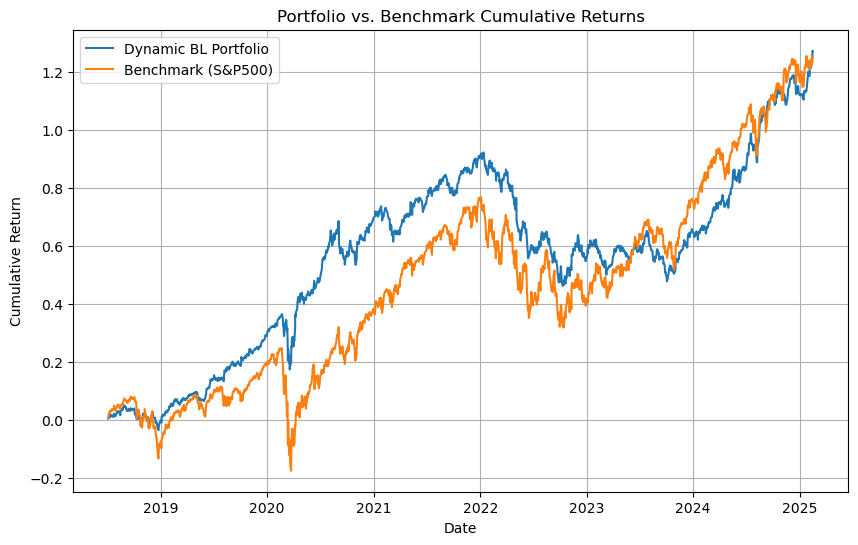

Portfolio Weights History (first 5 dates):
                  0         1         2         3         4         5   \
2018-07-05  0.119160  0.040478  0.031024  0.066897  0.080756  0.237563   
2018-08-03  0.112560  0.044185  0.023950  0.072920  0.083039  0.238192   
2018-09-04  0.117410  0.028024  0.039824  0.059435  0.081774  0.228833   
2018-10-03  0.109252  0.022758  0.064078  0.038281  0.066815  0.223705   
2018-11-01  0.105105  0.000780  0.061182  0.038025  0.062469  0.231424   

                      6         7         8         9         10        11  \
2018-07-05  3.382983e-10  0.044906  0.022256  0.026152  0.251506  0.042611   
2018-08-03  4.785133e-10  0.043973  0.020245  0.024091  0.251057  0.048758   
2018-09-04  9.140121e-10  0.069632  0.030015  0.020268  0.258203  0.038782   
2018-10-03  0.000000e+00  0.079894  0.044082  0.030537  0.264882  0.040885   
2018-11-01  3.011476e-03  0.090125  0.046697  0.025048  0.256366  0.052249   

                  12  
2018-07-05  0.036691

In [228]:
# Extract cumulative returns for portfolio and benchmark.
portfolio_cum_returns = result["portfolio_cum_returns"]
benchmark_cum_returns = result["benchmark_cum_returns"]


# Plot Cumulative Returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum_returns.index, portfolio_cum_returns, label = "Dynamic BL Portfolio")
plt.plot(benchmark_cum_returns.index, benchmark_cum_returns, label = "Benchmark (S&P500)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Portfolio vs. Benchmark Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


# Convert histories to DataFrames/Series for review and print them
portfolio_weights_df = result["portfolio_weights_df"]
portfolio_alpha_df = result["portfolio_alpha_df"]
mu_BL_df = result["mu_BL_df"]
transaction_cost_df = result["transaction_cost_df"]

print("Portfolio Weights History (first 5 dates):")
print(portfolio_weights_df.head())
print("\nPortfolio Alpha/Beta History (first 5 dates):")
print(portfolio_alpha_df.head())
print("\nBlack-Litterman Expected Returns History (first 5 dates):")
print(mu_BL_df.head())
print("\nTransaction Cost History (first 5 dates):")
print(transaction_cost_df.head())

In [229]:
def compute_performance_metrics(returns, risk_free_rate_daily, risk_free_rate_annual, confidence_level = 0.95):
    # Ensure returns is a Series 
    if isinstance(returns, pd.DataFrame):
        returns = returns.squeeze()
    
    cumulative_return = np.prod(1 + returns) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_vol

    
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Compute VaR and CVaR
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()

    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR (95%)": var,
        "CVaR (95%)": cvar
    }
    return metrics



portfolio_daily_returns_aligned = result["portfolio_daily_returns_aligned"]
benchmark_daily_returns_aligned = result["benchmark_daily_returns_aligned"]

portfolio_metrics = compute_performance_metrics(portfolio_daily_returns_aligned, risk_free_rate_daily, risk_free_rate_annual)
benchmark_metrics = compute_performance_metrics(benchmark_daily_returns_aligned, risk_free_rate_daily, risk_free_rate_annual)

print("Portfolio Performance Metrics:")
for key, value in portfolio_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nS&P500 Benchmark Performance Metrics:")
for key, value in benchmark_metrics.items():
    print(f"{key}: {value:.4f}")

Portfolio Performance Metrics:
Cumulative Return: 1.2718
Annualized Return: 0.1260
Annualized Volatility: 0.1061
Sharpe Ratio: 0.8099
Max Drawdown: -0.2394
VaR (95%): -0.0097
CVaR (95%): -0.0150

S&P500 Benchmark Performance Metrics:
Cumulative Return: 1.2536
Annualized Return: 0.1309
Annualized Volatility: 0.1985
Sharpe Ratio: 0.4581
Max Drawdown: -0.3392
VaR (95%): -0.0184
CVaR (95%): -0.0301


## 9. Portfolio's alpha and beta relative to the benchmark

In [231]:
portfolio_excess = portfolio_daily_returns_aligned - risk_free_rate_daily
benchmark_excess = benchmark_daily_returns_aligned - risk_free_rate_daily

# Align the two series 
df_excess = pd.concat([portfolio_excess, benchmark_excess], axis = 1).dropna()
df_excess.columns = ["portfolio_excess", "benchmark_excess"]

X = df_excess[["benchmark_excess"]].values  # Predictor (2D array)
y = df_excess["portfolio_excess"].values      # Response (1D array)

model_lin = LinearRegression().fit(X, y)

alpha_daily = model_lin.intercept_
beta = model_lin.coef_[0]

# Annualize the daily alpha  
alpha_annual = (1 + alpha_daily) ** 252 - 1

print("Portfolio Beta: {:.4f}".format(beta))
print("Portfolio Daily Alpha: {:.6f}".format(alpha_daily))
print("Portfolio Annualized Alpha: {:.4f}".format(alpha_annual))

Portfolio Beta: 0.4102
Portfolio Daily Alpha: 0.000132
Portfolio Annualized Alpha: 0.0339


## 10. Hypothesis Testing for Outperformance

We compute the daily difference between portfolio and benchmark, and perform a t-test on performance metrics

In [233]:
# Clean & align the two return series
port = (portfolio_daily_returns_aligned.dropna().loc[~portfolio_daily_returns_aligned.index.duplicated(keep='first')])
bench = (benchmark_daily_returns_aligned.dropna().loc[~benchmark_daily_returns_aligned.index.duplicated(keep='first')])
common_idx = port.index.intersection(bench.index)
port = port.loc[common_idx]
bench = bench.loc[common_idx]

# Rebalance dates
rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index

# Containers to hold one sample per window for each metric except daily return
samples = {
    "port_VaR": [],    "bench_VaR": [],
    "port_CVaR": [],   "bench_CVaR": [],
    "port_MDD": [],    "bench_MDD": [],
    "port_Sharpe": [], "bench_Sharpe": []
}

# Loop over each rebalance date => take the preceding "lookback" days as one sample
for date in rebalance_dates:
    if date not in port.index:
        continue
    idx = port.index.get_loc(date)
    if idx - lookback + 1 < 0:
        continue

    window_idx = port.index[idx - lookback + 1 : idx + 1]
    port_win = port.loc[window_idx]
    bench_win = bench.loc[window_idx]

    # Compute performance metrics on this window
    pm = compute_performance_metrics(port_win,risk_free_rate_daily,risk_free_rate_annual)
    bm = compute_performance_metrics(bench_win,risk_free_rate_daily,risk_free_rate_annual)

    # Collect metrics
    samples["port_VaR"].append(pm["VaR (95%)"])
    samples["bench_VaR"].append(bm["VaR (95%)"])
    samples["port_CVaR"].append(pm["CVaR (95%)"])
    samples["bench_CVaR"].append(bm["CVaR (95%)"])
    samples["port_MDD"].append(pm["Max Drawdown"])
    samples["bench_MDD"].append(bm["Max Drawdown"])
    samples["port_Sharpe"].append(pm["Sharpe Ratio"])
    samples["bench_Sharpe"].append(bm["Sharpe Ratio"])

# Paired t‑tests on each windowed metric
for m_label, metric_name in [
    ("VaR", "VaR (95%)"),
    ("CVaR", "CVaR (95%)"),
    ("MDD", "Max Drawdown"),
    ("Sharpe", "Sharpe Ratio"),
]:
    a = np.array(samples[f"port_{m_label}"])
    b = np.array(samples[f"bench_{m_label}"])

    # Truncate to same length and drop NaNs
    n = min(len(a), len(b))
    a, b = a[:n], b[:n]
    mask = ~np.isnan(a) & ~np.isnan(b)
    a, b = a[mask], b[mask]

    if len(a) < 2:
        print(f"{metric_name}: not enough data for t-test\n")
        continue

    t_stat, p_value = stats.ttest_rel(a, b)
    print(f"{metric_name}:")
    print(f"  Portfolio mean = {a.mean():.4f}, Benchmark mean = {b.mean():.4f}")
    print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print("  =>", 
          "significant difference" if p_value < 0.05 else "no significant difference",
          "\n")

# One-sample t-test on daily return differences
# Ensure 1D, no duplicates
portfolio_unique = portfolio_daily_returns_aligned.loc[~portfolio_daily_returns_aligned.index.duplicated(keep = "first")].squeeze()
benchmark_unique = benchmark_daily_returns_aligned.loc[~benchmark_daily_returns_aligned.index.duplicated(keep = "first")].squeeze()

# Align
common_index = portfolio_unique.index.intersection(benchmark_unique.index)
portfolio_aligned = portfolio_unique.loc[common_index]
benchmark_aligned = benchmark_unique.loc[common_index]

daily_diff = portfolio_aligned - benchmark_aligned
daily_diff = daily_diff.dropna()

t_stat, p_value = stats.ttest_1samp(daily_diff, 0)

if np.ndim(t_stat) > 0:
    t_stat = t_stat.item()
if np.ndim(p_value) > 0:
    p_value = p_value.item()

mean_daily_diff = daily_diff.mean()


print("Daily Return:")
print(f"  Portfolio mean = {portfolio_aligned.mean():.4f}, Benchmark mean = {benchmark_aligned.mean():.4f}")
print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
print("  =>", 
      "significant difference" if p_value < 0.05 else "no significant difference",
      "\n")

VaR (95%):
  Portfolio mean = -0.0096, Benchmark mean = -0.0189
  t-statistic = 11.9643, p-value = 0.0000
  => significant difference 

CVaR (95%):
  Portfolio mean = -0.0137, Benchmark mean = -0.0261
  t-statistic = 12.1373, p-value = 0.0000
  => significant difference 

Max Drawdown:
  Portfolio mean = -0.0700, Benchmark mean = -0.1185
  t-statistic = 8.0450, p-value = 0.0000
  => significant difference 

Sharpe Ratio:
  Portfolio mean = 1.1153, Benchmark mean = 0.9066
  t-statistic = 1.3540, p-value = 0.1799
  => no significant difference 

Daily Return:
  Portfolio mean = 0.0005, Benchmark mean = 0.0006
  t-statistic = -0.3093, p-value = 0.7572
  => no significant difference 



## 11. Sensitivity Analysis with Monte Carlo Simulation

What is parameter sensitivity analysis ? Instead of evaluating our strategy at just a fixed value of $\tau$, $\delta$, or other varaibles, we can simulate many scenarios in which these parameters vary randomly within realistic ranges. This also helps us understand the stability of our model.

Here we test our model with different values of $\tau$.

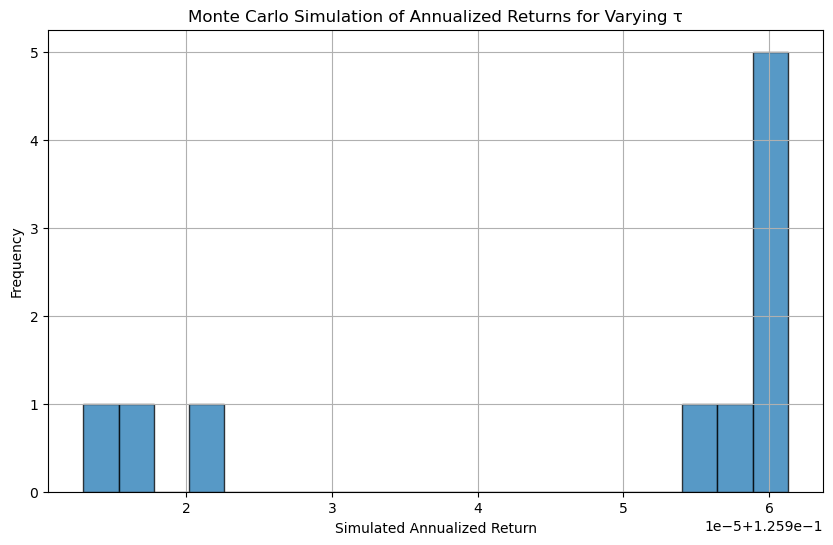

Monte Carlo Simulation Summary for Annualized Returns:
Mean Annualized Return: 0.1259
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1259
Max Annualized Return: 0.1260


In [235]:
n_simulations = 10 
tau_samples = np.random.uniform(0.015, 0.035, n_simulations)

annualized_returns = []

for tau in tau_samples:
    # Run the simulation with the current tau.
    result = Monte_Carlo_simulate(tau)
    portfolio_cum_returns = result["portfolio_cum_returns"]  
    
    n_trading_days = len(portfolio_cum_returns)
    final_cum_return = portfolio_cum_returns.iloc[-1]
    annualized_return = (1 + final_cum_return) ** (252 / n_trading_days) - 1
    annualized_returns.append(annualized_return)

annualized_returns = np.array(annualized_returns)



# Plot the histogram of simulated annualized returns.
plt.figure(figsize=(10, 6))
plt.hist(annualized_returns, bins=20, edgecolor='k', alpha=0.75)
plt.xlabel("Simulated Annualized Return")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation of Annualized Returns for Varying τ")
plt.grid(True)
plt.show()


# Print summary statistics.
print("Monte Carlo Simulation Summary for Annualized Returns:")
print("Mean Annualized Return: {:.4f}".format(np.mean(annualized_returns)))
print("Std. Dev. of Annualized Return: {:.4f}".format(np.std(annualized_returns)))
print("Min Annualized Return: {:.4f}".format(np.min(annualized_returns)))
print("Max Annualized Return: {:.4f}".format(np.max(annualized_returns)))

Here we test our model different view vector Q

We inject a zero-mean Gaussian noise term ε into Q, where εᵢ ~ N(0, Ωᵢᵢ).
In the Black–Litterman framework, Ω is the diagonal matrix of view uncertainties,
so sampling noise with variance Ωᵢᵢ explores plausible errors around each view.

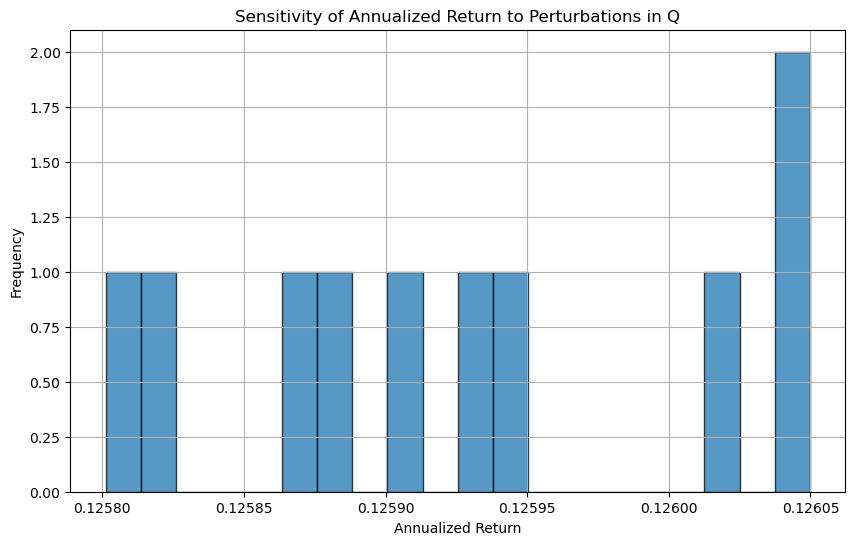

Q-Perturbation Sensitivity Summary:
Mean Annualized Return: 0.1259
Std. Dev. of Annualized Return: 0.0001
Min Annualized Return: 0.1258
Max Annualized Return: 0.1260


In [237]:

n_Q_sims = 10
tau0      = 0.025
annualized_returns_Q = []

for i in range(n_Q_sims):
    # Turn on perturbation
    PERTURB_Q = True

    # Run backtest as usual (will now use perturbed Q internally)
    result = Monte_Carlo_simulate(tau0)
    port_cum = result["portfolio_cum_returns"]

    # Compute annualized return
    n_days    = len(port_cum)
    final_ret = port_cum.iloc[-1]
    ann_ret   = (1 + final_ret) ** (252 / n_days) - 1
    annualized_returns_Q.append(ann_ret)

    # Turn off perturbation
    PERTURB_Q = False

annualized_returns_Q = np.array(annualized_returns_Q)

# Plot distribution
plt.figure(figsize=(10,6))
plt.hist(annualized_returns_Q, bins=20, edgecolor='k', alpha=0.75)
plt.title("Sensitivity of Annualized Return to Perturbations in Q")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print summary statistics
print("Q-Perturbation Sensitivity Summary:")
print("Mean Annualized Return: {:.4f}".format(np.mean(annualized_returns_Q)))
print("Std. Dev. of Annualized Return: {:.4f}".format(np.std(annualized_returns_Q)))
print("Min Annualized Return: {:.4f}".format(np.min(annualized_returns_Q)))
print("Max Annualized Return: {:.4f}".format(np.max(annualized_returns_Q)))